# Figure 5
Plots for future devil population with evolved natural immunity intervention

In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '../GillesPy2')))

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,mark_inset)

In [3]:
from gillespy2 import TauHybridCSolver

In [4]:
from dask.distributed import Client
from dask import delayed

In [5]:
from Devils_DFTD_2_Stage_Infection import DevilsDFTD2StageInfection
from Simulation import Simulation, devil_pop
from ParameterSweep import ParameterSweep

In [6]:
c = Client(n_workers=8, threads_per_worker=1)

In [7]:
dates = []
year = 1985
while len(dates) < 1001:
    for month in ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]:
        dates.append(f"{month} {year}")
    year += 1

## Load Simulation

In [8]:
def get_params(key):
    params = [param.split(":") for param in key.split(",")]
    return {param[0]: float(param[1]) for param in params}

In [9]:
def load_simulation(data_path, key):
    if os.path.exists(data_path):
        with open(data_path, "rb") as data_file:
            sim = pickle.load(data_file)
        return Simulation.load_state(sim)
    
    data_path = "./ParameterSweeps/DevilsDFTD2StageInfectionWithImmunityState.p"
    if os.path.exists(data_path):
        with open(data_path, "rb") as state_file:
            sim = pickle.load(state_file)['job'].results[key]
        return Simulation.load_state(sim)
    
    model = DevilsDFTD2StageInfection(devil_pop, interventions="immunity")
    
    sol = delayed(TauHybridCSolver)(model=model, variable=True)
    
    params = get_params(key)
    
    sim = Simulation(model, variables=params)
    sim.configure(solver=sol)
    return sim

## Run Simulation for figure 5a

In [10]:
fig_5a_path = "figure_data/Fig5a-data.p"
fig_5a_key = "immunity_growth_rate:0.0075,immunity_max_level:70,immunity_start:444"

In [11]:
fig_5a_sim = load_simulation(fig_5a_path, fig_5a_key)

In [12]:
%time _ = fig_5a_sim.run(use_existing_results=True)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 5.01 µs


In [13]:
if not os.path.exists(fig_5a_path):
    with open(fig_5a_path, "wb") as fig_5a_data_file:
        pickle.dump(fig_5a_sim, fig_5a_data_file)

## Plots for figure 5a

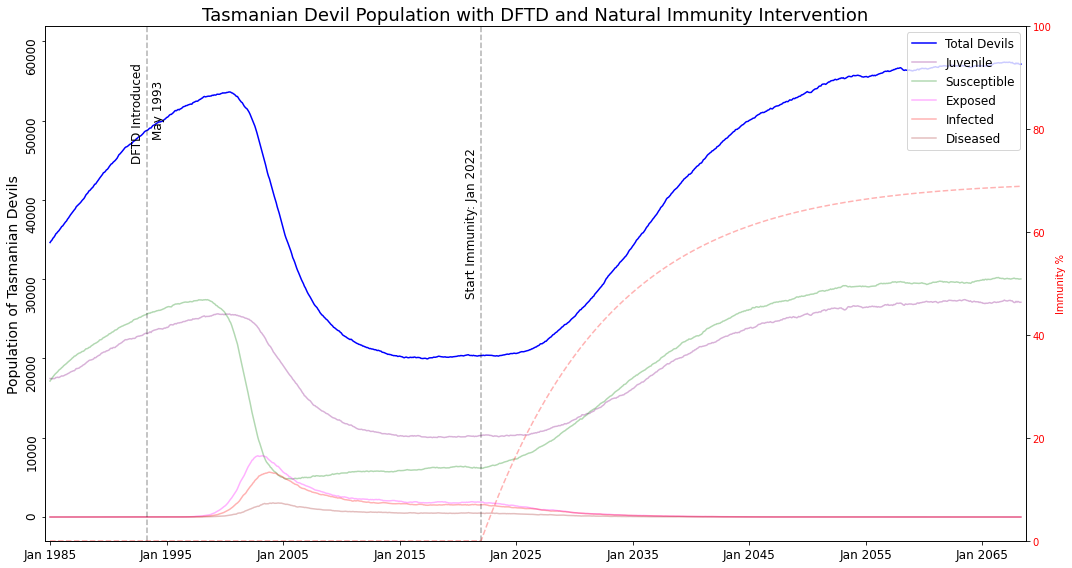

In [14]:
fig_5a_sim.plot()

In [15]:
# fig_5a_sim.plot(save_fig="figures/DFTDmodel_sec4_immunity.pdf")

## Run Simulation for figure 5b

In [16]:
fig_5b_path = "figure_data/Fig5b-data.p"
fig_5b_key = "immunity_growth_rate:0.0075,immunity_max_level:50,immunity_start:504"

In [17]:
fig_5b_sim = load_simulation(fig_5b_path, fig_5b_key)

In [18]:
%time _ = fig_5b_sim.run(use_existing_results=True, store_all_results=True)

CPU times: user 11 µs, sys: 4 µs, total: 15 µs
Wall time: 11 µs


In [19]:
if not os.path.exists(fig_5b_path):
    with open(fig_5b_path, "wb") as fig_5b_data_file:
        pickle.dump(fig_5b_sim, fig_5b_data_file)

## Plots for figure 5b

In [20]:
def plot_figure(sim, start=0, alpha=0.3, plot_observed=False, plot_immunity_level=True, save_fig=None):
    carry_cap = int(max(devil_pop)*1.16)
    dftd_start = int(sim.result[0].model.listOfParameters['DFTD_introduction'].value)

    x = sim.result[0]['time'][start:]
    text_offset = (sim.result[0]['time'].size - start) / 601

    fig, ax1 = plt.subplots(figsize=[15, 8])
    title = f"Tasmanian Devil Population with DFTD and Natual Immunity Intervention"
    plt.title(title, fontsize=18)
    ax1.set_ylabel("Population of Tasmanian Devils", fontsize=14)

    for i, result in enumerate(sim.result):
        spec_list = [sim.result[i]['Juvenile'], sim.result[i]['Susceptible'], sim.result[i]['Exposed'],
                 sim.result[i]['Infected'], sim.result[i]['Diseased']]
        total_devils = np.add.reduce(spec_list)
        if i == 0:
            ax1.plot(x, total_devils[start:], color='blue', label='Total Devils')
        else:
            ax1.plot(x, total_devils[start:], color='blue', alpha=alpha)

    if plot_observed:
        ax1.plot(range(len(devil_pop)), devil_pop, '--k', label='Observed')

    # DFTD Introduction
    if start <= dftd_start:
        ax1.plot([dftd_start, dftd_start], [-3000, carry_cap], '--k', alpha=0.3)
        ax1.text(dftd_start - 10 * text_offset, 45000, "DFTD Introduced",
                 rotation="vertical", color="black", fontsize=12)
        ax1.text(dftd_start + 3 * text_offset, 48000, dates[dftd_start],
                 rotation="vertical", color="black", fontsize=12)

    # Immunity
    if sim.variables is not None and "immunity_start" in sim.variables.keys():
        immunity_start = int(sim.variables['immunity_start'])
    else: 
        immunity_start = int(sim.result.model.listOfParameters['immunity_start'].value)

    ax1.plot([immunity_start, immunity_start], [-3000, carry_cap], '--k', alpha=0.3)
    ax1.text(immunity_start - 10 * text_offset, 28000, f"Start Immunity: {dates[immunity_start]}",
             rotation="vertical", color="black", fontsize=12)

    if plot_immunity_level:
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.plot(sim.result[0]['immunity_level'], '--r', alpha=0.3, label="immunity")
        ax2.set_ylim(0,100)
        ax2.set_yticks(ax2.get_yticks())
        ax2.set_ylabel("Immunity %", color="red")
        ax2.tick_params(axis='y', labelcolor="red")

    ax1.set_ylim(-3000, carry_cap)
    ax1.set_xlim(-5, 1005)
    x_ticks, x_ticklabels = sim._get_x_ticklabels()
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_ticklabels)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.tick_params(axis='y',labelsize=12, labelrotation=90)
    ax1.legend(loc='upper right', fontsize=12)
    fig.tight_layout()

    if save_fig is not None:
        plt.savefig(save_fig)

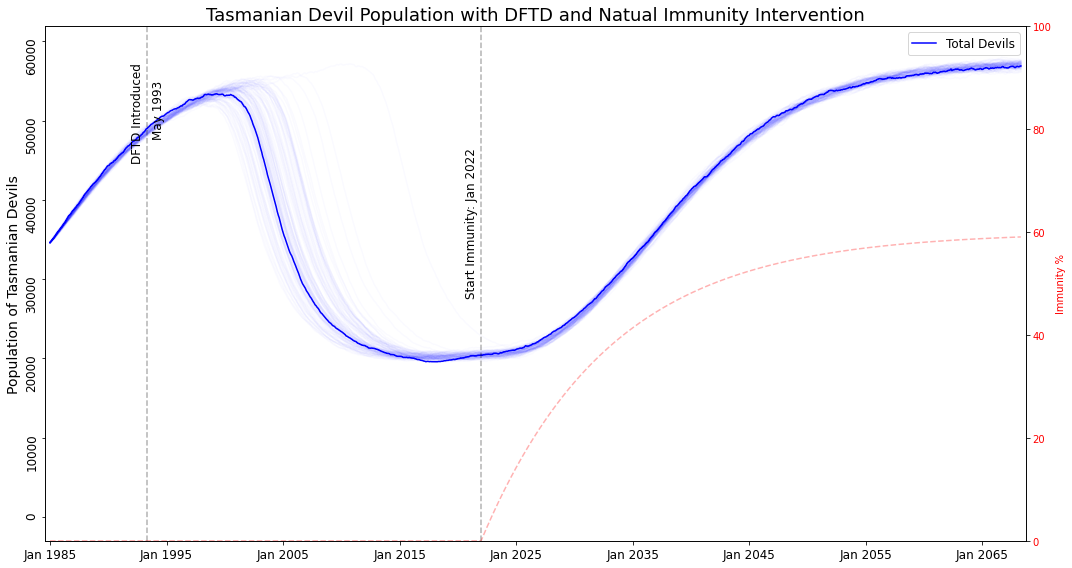

In [21]:
plot_figure(fig_5b_sim, alpha=0.02)

In [22]:
# plot_figure(fig_5b_sim, alpha=0.02, save_fig="figures/DFTDmodel_sec4_immunity-variable-success.pdf")

In [23]:
c.close()